https://projecteuler.net/problem=323

In [1]:
import random
import math
from statistics import mean, stdev

import matplotlib.pyplot as plt


def run_once(n_bits: int) -> int:
    x = 0
    n = 0
    max_ = 2**n_bits - 1
    while x != max_:
        y = random.getrandbits(n_bits)
        x |= y
        n += 1
    return n


def run_n_times(n_bits: int, n: int) -> tuple[float, float]:
    vals = [run_once(n_bits) for _ in range(n)]
    return mean(vals), stdev(vals)


In [2]:
n_bits_values = list(range(2, 100))
expected_times_mean_std = [run_n_times(n_b, 100_000) for n_b in n_bits_values]
means, stds = zip(*expected_times_mean_std)

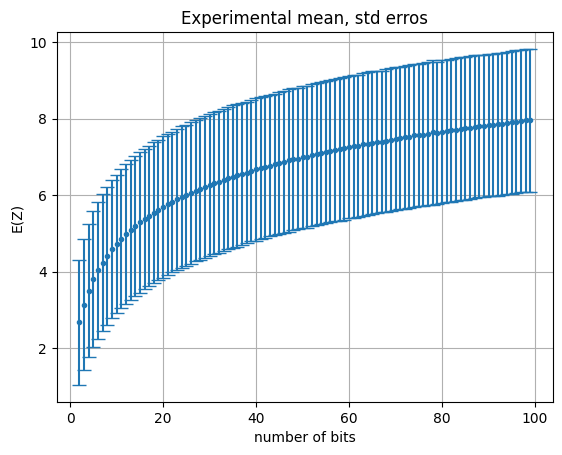

In [3]:
plt.errorbar(
    n_bits_values,
    means,
    yerr=stds,
    fmt=".",
    capsize=5,
)
plt.title("Experimental mean, std erros")
plt.ylabel("E(Z)")
plt.xlabel("number of bits")
plt.grid()
plt.show()

## Derivation (math!)

This process can be described using a set of $n$ i.i.d. geometric random variables $\{x_i\}_{i=1}^n$:
$$
p(k) := \mathbb{P}(x_i = k) = \left(1 - \frac{1}{2}\right)^{k-1} \cdot \frac{1}{2} = \frac{1}{2^k}, \;\;\;\; \forall i=1..n.
$$
That is, the probability that the bit $i$ is turned on on step $k$ is given by $p_i(k)$ (PMF — probability mass function).

The time at which the last bit is turned on follows the maximum of the set of $x_i$:
$$
z = \max_{i=1..n} (x_i).
$$
Then, we want to find $E_{32}$ with $E_n := \mathbb{E}(z)$.

It can be shown that given the c.d.f. $F_x(k):=\mathbb{P}(x_i \leq k)$ of $x_i$, $\forall i=1..n$, the c.d.f. of $z$ is 
$$
\begin{align*}
F_z(k) &:= \mathbb{P}(\max_{i=1..n} (x_i) \leq k) = \mathbb{P}(x_1 \leq k, \dots, x_n \leq k) \\
&= \prod_{j=1}^n \left(\mathbb{P}(x_i \leq k)\right)^j = \prod_{j=1}^n F_x(k) = F_x^n(k),
\end{align*}
$$
since the maximum of a set of numbers is less than or equal to $k$ if and only if each individual number is also at most $k$ (see a more detailed proof [here](https://max.pm/posts/max_dist/)).

Now, let us derive a formula for $F_x(k)$ given $p(k)$:
$$
F_x(k) = \mathbb{P}(x_i \leq k) = \frac{\sum_{m=1}^k p(m)}{\sum_{m=1}^\infty p(m)} = \frac{\frac{1 - (1/2)^k}{1 - 1/2} - 1}{\frac{1}{1 - 1/2} - 1} = 1 - \frac{1}{2^k}.
$$

Then, $F_z(k) = F_x^n(k) = \left(1 - \frac{1}{2^{k}}\right)^n$. 

We can easily convert from CDF to PMF by using the following argument:
$$
\begin{align*}
p_z(k) &:= \mathbb{P}(z = k) = \mathbb{P}(z \leq k) - \mathbb{P}(z \leq k-1) \\
&= F_z(k) - F_z(k-1) = \left(1-\frac{1}{2^{k}}\right)^{n}-\left(1-\frac{1}{2^{k-1}}\right)^{n}.
\end{align*}
$$
$p_z(k)$ gives us the probability to terminate after $k$ steps.

And finally,
$$
E_n = \sum_{k=1}^\infty k\,p_z(k) = \sum_{k=1}^\infty k\left[\left(1-\frac{1}{2^{k}}\right)^{n}-\left(1-\frac{1}{2^{k-1}}\right)^{n}\right].
$$

In [4]:
def f_z(k: int, n: int) -> float:
    return abs(1 - 1 / 2 ** k) ** n


def expected_analytical(n_bits: int) -> float:
    return sum(k * (f_z(k, n_bits) - f_z(k - 1, n_bits)) for k in range(1, 100))


In [5]:
round(expected_analytical(32), 10)

6.3551758451

In [6]:
means_analytical = [expected_analytical(n_b) for n_b in n_bits_values]

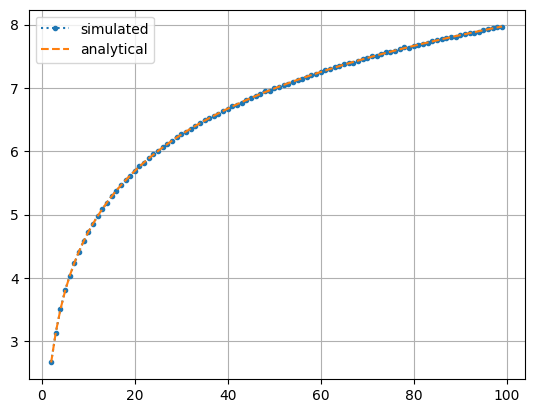

In [7]:
plt.plot(n_bits_values, means, ".:", label="simulated")
plt.plot(n_bits_values, means_analytical, "--", label="analytical")
plt.legend()
plt.grid()
plt.show()